# Model Development

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



Using TensorFlow backend.


In [2]:
df = df = pd.read_csv(project_path + '/data/raw/data.csv', index_col=0)
df.sort_values('time', inplace=True)
df.drop(['index', 'volumeto'], axis=1, inplace=True)

df.head()

,volumefrom,open,high,close,low,time
44022,0.00,73.7,73.7,73.7,73.7,1364086800
44023,0.00,73.7,73.7,73.7,73.7,1364090400
44024,0.00,73.7,73.7,73.7,73.7,1364094000
44025,7.42,73.7,73.7,68.2,68.2,1364097600
44026,0.00,68.2,68.2,68.2,68.2,1364101200


In [3]:
sample = df.iloc[20000:,:]
sample.head()

,volumefrom,open,high,close,low,time
28004,802.53,260.40,260.80,260.41,259.94,1436054400
28005,3441.33,260.41,262.83,262.27,260.24,1436058000
28006,1984.04,262.27,262.99,261.66,261.39,1436061600
28007,1698.54,261.66,263.41,262.52,261.72,1436065200
28008,780.67,262.52,262.83,262.62,261.48,1436068800


In [32]:
N_FEATURES = len(df.columns)
INPUT_HOURS = 24
PREDICT_HOURS = 6


In [33]:
## Ripped from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [34]:
X = series_to_supervised(data=sample, n_in=INPUT_HOURS, n_out=PREDICT_HOURS)
X = X.iloc[:,:-(PREDICT_HOURS*N_FEATURES)]
X.head()

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var1(t-23),var2(t-23),var3(t-23),var4(t-23),...,var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
24026,802.53,260.40,260.80,260.41,259.94,1.436054e+09,3441.33,260.41,262.83,262.27,...,271.29,268.56,267.18,1.436130e+09,1447349.53,268.56,270.83,269.22,267.78,1.436134e+09
24027,3441.33,260.41,262.83,262.27,260.24,1.436058e+09,1984.04,262.27,262.99,261.66,...,270.83,269.22,267.78,1.436134e+09,1124642.99,269.22,270.67,269.82,268.75,1.436137e+09
24028,1984.04,262.27,262.99,261.66,261.39,1.436062e+09,1698.54,261.66,263.41,262.52,...,270.67,269.82,268.75,1.436137e+09,2609069.48,269.82,272.09,270.67,269.92,1.436141e+09
24029,1698.54,261.66,263.41,262.52,261.72,1.436065e+09,780.67,262.52,262.83,262.62,...,272.09,270.67,269.92,1.436141e+09,2383595.86,270.67,272.08,269.05,268.37,1.436144e+09
24030,780.67,262.52,262.83,262.62,261.48,1.436069e+09,903.18,262.62,263.12,261.74,...,272.08,269.05,268.37,1.436144e+09,1153986.28,269.05,270.09,267.55,267.42,1.436148e+09


In [35]:
Y = series_to_supervised(data=list(sample['close']), n_in=INPUT_HOURS, n_out=PREDICT_HOURS)
Y.head()

,var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),...,var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5)
24,260.41,262.27,261.66,262.52,262.62,261.74,261.32,260.02,258.90,258.87,...,269.42,270.30,268.56,269.22,269.82,270.67,269.05,267.55,268.46,267.62
25,262.27,261.66,262.52,262.62,261.74,261.32,260.02,258.90,258.87,258.87,...,270.30,268.56,269.22,269.82,270.67,269.05,267.55,268.46,267.62,269.31
26,261.66,262.52,262.62,261.74,261.32,260.02,258.90,258.87,258.87,259.48,...,268.56,269.22,269.82,270.67,269.05,267.55,268.46,267.62,269.31,268.77
27,262.52,262.62,261.74,261.32,260.02,258.90,258.87,258.87,259.48,259.19,...,269.22,269.82,270.67,269.05,267.55,268.46,267.62,269.31,268.77,269.55
28,262.62,261.74,261.32,260.02,258.90,258.87,258.87,259.48,259.19,260.54,...,269.82,270.67,269.05,267.55,268.46,267.62,269.31,268.77,269.55,271.87


# train test split

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05, shuffle=True)
Y_test_cache = Y_test
Y_train = Y_train.iloc[:,-PREDICT_HOURS:]
Y_test = Y_test.iloc[:,-PREDICT_HOURS:]
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

# preprocessing

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
def shape_model_data(data, n_features):
    model_data = data.reshape((data.shape[0], INPUT_HOURS, n_features))
    return model_data
X_train_3D = shape_model_data(X_train, N_FEATURES)
X_test_3D = shape_model_data(X_test, N_FEATURES)
X_train_3D[0,:,:]

array([[3.72924998e-04, 3.83415577e-01, 3.86082676e-01, 3.86352970e-01,
        3.84381165e-01, 8.01231717e-01],
       [2.09179244e-04, 3.86407102e-01, 3.85646870e-01, 3.86789085e-01,
        3.87153645e-01, 8.01231717e-01],
       [2.00013429e-04, 3.86809002e-01, 3.85039182e-01, 3.84686133e-01,
        3.85425526e-01, 8.01231717e-01],
       [2.88143886e-04, 3.84686133e-01, 3.85754677e-01, 3.87536200e-01,
        3.85271129e-01, 8.01231717e-01],
       [2.81021506e-04, 3.87536200e-01, 3.85941815e-01, 3.83719939e-01,
        3.84172395e-01, 8.01231717e-01],
       [2.81912464e-04, 3.83727088e-01, 3.83308161e-01, 3.80653856e-01,
        3.82447354e-01, 8.01231717e-01],
       [2.51478249e-04, 3.80655899e-01, 3.81825810e-01, 3.83391065e-01,
        3.82638170e-01, 8.01231717e-01],
       [2.80812661e-04, 3.83391065e-01, 3.81714951e-01, 3.82009694e-01,
        3.82506343e-01, 8.01231717e-01],
       [2.61370528e-04, 3.82009694e-01, 3.80919617e-01, 3.80264212e-01,
        3.82158051e-01, 

In [78]:
def lstm_model(input_shape, num_outputs):
    model = Sequential()
    
    model.add(LSTM(64, input_shape=input_shape, activation='linear', return_sequences=True))
    
    model.add(Dropout(rate=0.1))
    
    model.add(LSTM(64, activation='linear'))
    
    model.add(Dense(num_outputs, activation='linear'))
    
    return model


In [79]:
model = lstm_model(X_train_3D.shape[1:], PREDICT_HOURS)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 24, 64)            18176     
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 64)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 51,590
Trainable params: 51,590
Non-trainable params: 0
_________________________________________________________________


In [80]:
N_EPOCHS = 10
BATCH_SIZE = 128

In [81]:
from keras.optimizers import Adam
model.compile(loss='mae', optimizer=Adam(lr=0.0001))

fit = model.fit(X_train_3D, Y_train, 
                    epochs=N_EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_3D, Y_test))


Train on 24694 samples, validate on 1300 samples
Epoch 1/10
24694/24694 [==============================] - 25s 1ms/step - loss: 1859.4482 - val_loss: 403.1414
Epoch 2/10
24694/24694 [==============================] - 24s 961us/step - loss: 381.3090 - val_loss: 341.1904
Epoch 3/10
24694/24694 [==============================] - 24s 985us/step - loss: 333.7678 - val_loss: 302.8991
Epoch 4/10
24694/24694 [==============================] - 23s 939us/step - loss: 295.4716 - val_loss: 264.6468
Epoch 5/10
24694/24694 [==============================] - 24s 967us/step - loss: 263.1913 - val_loss: 226.9879
Epoch 6/10
24694/24694 [==============================] - 24s 962us/step - loss: 228.4862 - val_loss: 204.6766
Epoch 7/10
24694/24694 [==============================] - 25s 1ms/step - loss: 196.3000 - val_loss: 169.1677
Epoch 8/10
24694/24694 [==============================] - 25s 1ms/step - loss: 173.1102 - val_loss: 145.5421
Epoch 9/10
24694/24694 [==============================] - 23s 950us/

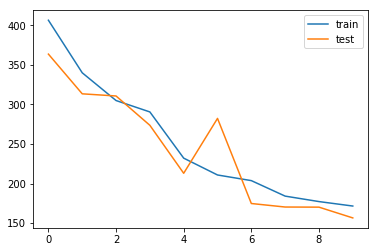

In [56]:
import matplotlib.pyplot as plt
plt.plot(fit.history['loss'], label='train')
plt.plot(fit.history['val_loss'], label='test')
plt.legend()

## Look at some predictions

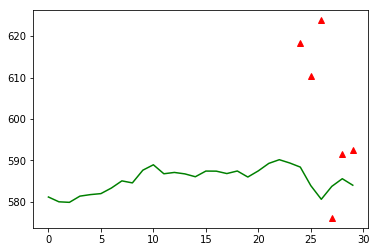

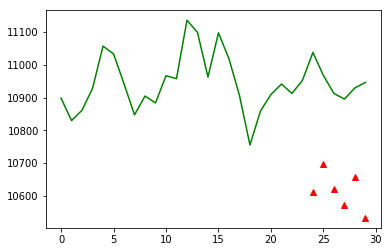

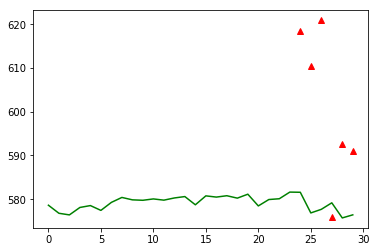

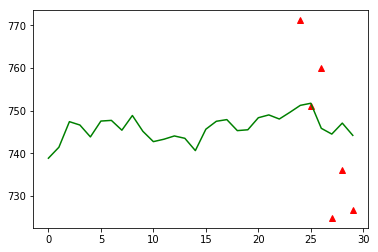

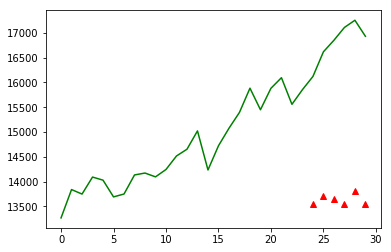

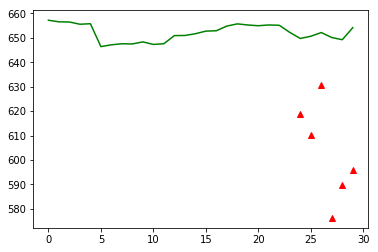

In [57]:

for ix in np.random.randint(0,Y_test_cache.shape[0],6):
    plt.figure()
    s = X_test_3D[ix,:,:]
    predict = fit.model.predict(s.reshape(1, s.shape[0], s.shape[1])).reshape(6)
    actual = Y_test_cache.iloc[ix]
    plt.plot(range(24,30), predict, 'r^', range(30), actual, 'g-')

In [70]:
X_train.shape

(24694, 144)

In [66]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, Y_train)



In [73]:
lr_model.score(X_test, Y_test)

0.9989152788629398

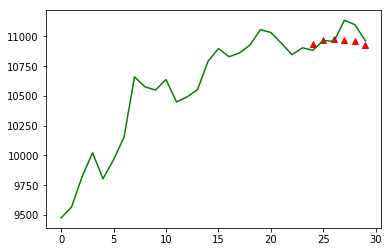

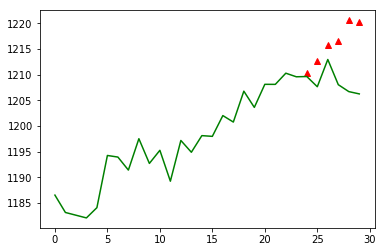

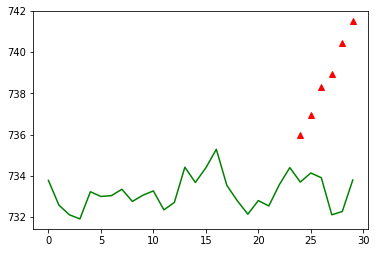

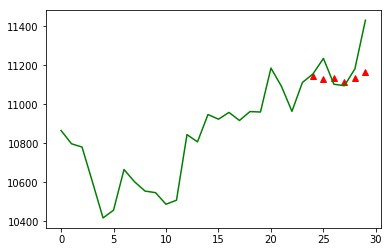

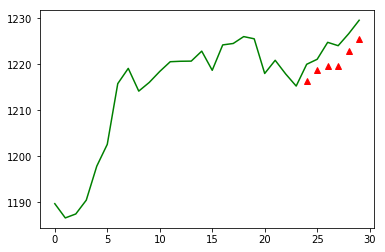

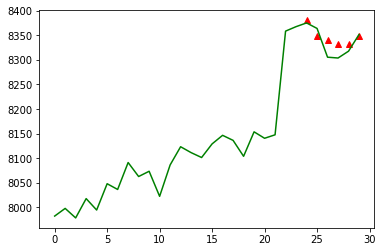

In [75]:
lr_predict = lr_model.predict(X_test)
for ix in np.random.randint(0,Y_test_cache.shape[0],6):
    plt.figure()
    
    actual = Y_test_cache.iloc[ix]
    plt.plot(range(24,30), lr_predict[ix], 'r^', range(30), actual, 'g-')

In [84]:
import pickle
with open(project_path + '/models/linear_model_btc.pkl', 'wb') as output_file:
    s = pickle.dump(lr_model, output_file)
